# Models Evaluation

In this notebook, I will evaluate the models that I have trained in the previous notebooks. The models are:
- DETR (Detection Transformer)
- YOLOv11
- Faster R-CNN

The evalution methods used will be the following:
- Precision & Recall
- F1 Score
- mAP (mean Average Precision)
- Overall ROC Curve

In addition to these, the evaluation will also produce some sample predictions for each model to get a sense of how well they are performing.

## Various Imports

In [5]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import glob
import re
import random
from pathlib import Path

## Helper Functions/Classes

### Evaluation Functions

These functions will be used to calculate the metrics for the models. 
These incliude the IoU (intersection over union) and the mAP (mean Average Precision) functions.

In [6]:
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two boxes."""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    if interArea == 0:
        return 0.0
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return interArea / float(box1Area + box2Area - interArea)

def convert_yolo_box_to_xyxy(box, img_width, img_height):
    """Convert YOLO box format [x_center, y_center, w, h] to absolute [xmin, ymin, xmax, ymax]."""
    x_center, y_center, w, h = box
    xmin = (x_center - w/2) * img_width
    ymin = (y_center - h/2) * img_height
    xmax = (x_center + w/2) * img_width
    ymax = (y_center + h/2) * img_height
    return [xmin, ymin, xmax, ymax]

def compute_precision_recall_f1(tp, fp, fn):
    """Compute precision, recall, and F1 score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

def compute_average_precision(recalls, precisions):
    """Compute Average Precision (AP) using numerical integration."""
    mrec = np.concatenate(([0.0], recalls, [1.0]))
    mpre = np.concatenate(([0.0], precisions, [0.0]))
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = np.maximum(mpre[i], mpre[i + 1])
    indices = np.where(mrec[1:] != mrec[:-1])[0]
    return np.sum((mrec[indices + 1] - mrec[indices]) * mpre[indices + 1])

### Visual Tests of Evaluation Functions

These are very important to make sure that the evaluation functions are working as expected. We wouldn't want to evaluate our models incorrectly.

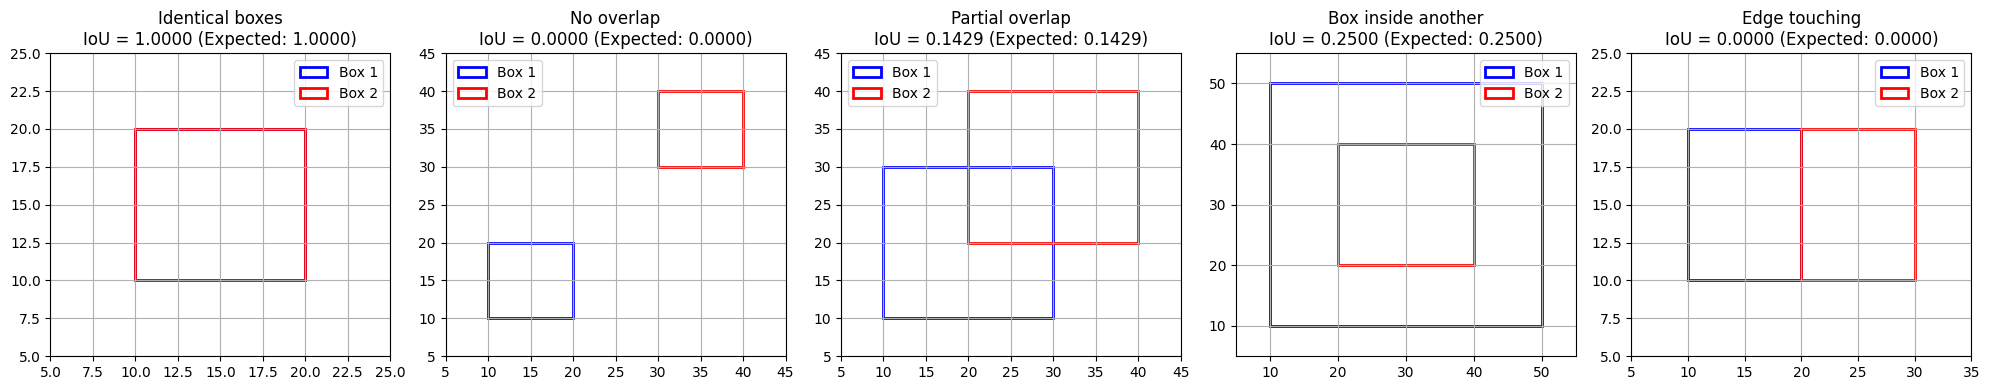

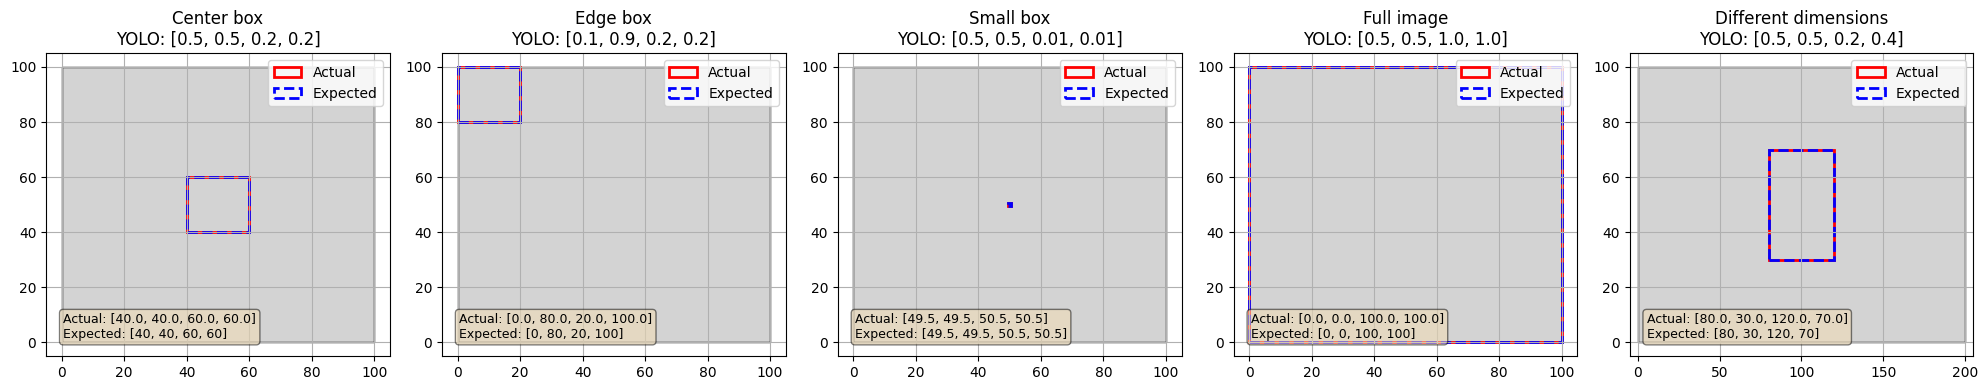

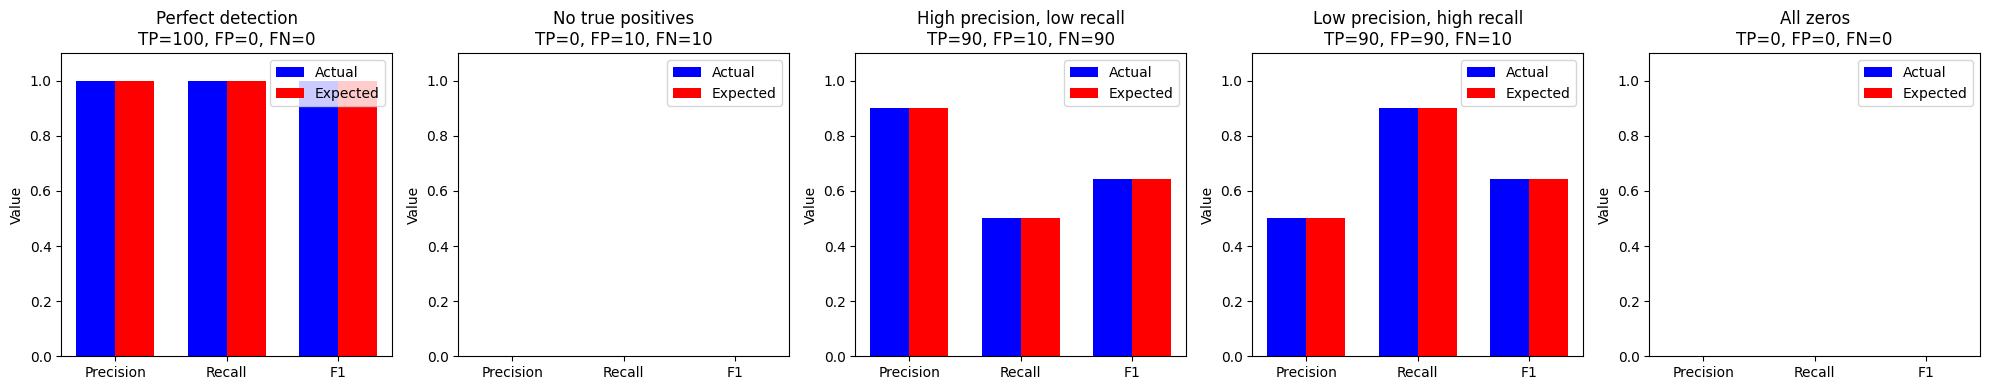

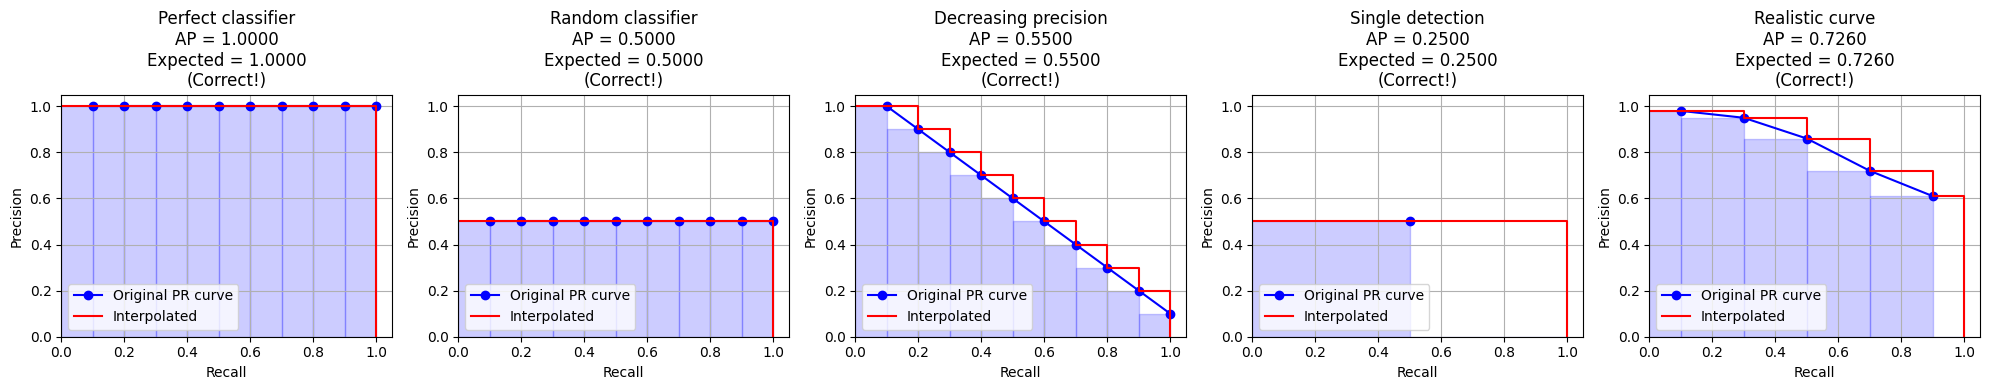

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_yolo_conversion_test_cases():
    """Visualize YOLO to XYXY conversion test cases, showing both actual and expected results."""
    test_cases = [
        {
            "name": "Center box",
            "yolo": [0.5, 0.5, 0.2, 0.2],
            "img_dims": (100, 100),
            "expected": [40, 40, 60, 60]
        },
        {
            "name": "Edge box",
            "yolo": [0.1, 0.9, 0.2, 0.2],
            "img_dims": (100, 100),
            "expected": [0, 80, 20, 100]
        },
        {
            "name": "Small box",
            "yolo": [0.5, 0.5, 0.01, 0.01],
            "img_dims": (100, 100),
            "expected": [49.5, 49.5, 50.5, 50.5]
        },
        {
            "name": "Full image",
            "yolo": [0.5, 0.5, 1.0, 1.0],
            "img_dims": (100, 100),
            "expected": [0, 0, 100, 100]
        },
        {
            "name": "Different dimensions",
            "yolo": [0.5, 0.5, 0.2, 0.4],
            "img_dims": (200, 100),
            "expected": [80, 30, 120, 70]
        }
    ]
    
    _, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    for i, test_case in enumerate(test_cases):
        yolo_box = test_case["yolo"]
        img_dims = test_case["img_dims"]
        name = test_case["name"]
        expected = test_case["expected"]
        
        actual = convert_yolo_box_to_xyxy(yolo_box, img_dims[0], img_dims[1])
        
        ax = axs[i]
        # Draw the image boundaries
        ax.add_patch(Rectangle((0, 0), img_dims[0], img_dims[1], 
                              linewidth=1, edgecolor='black', facecolor='lightgray'))
        
        # Draw the converted box (actual result)
        ax.add_patch(Rectangle((actual[0], actual[1]), actual[2]-actual[0], actual[3]-actual[1], 
                              linewidth=2, edgecolor='red', facecolor='none', label='Actual'))
        
        # Draw the expected box
        ax.add_patch(Rectangle((expected[0], expected[1]), expected[2]-expected[0], expected[3]-expected[1], 
                              linewidth=2, edgecolor='blue', linestyle='--', facecolor='none', label='Expected'))
        
        ax.set_xlim(-5, img_dims[0]+5)
        ax.set_ylim(-5, img_dims[1]+5)
        ax.set_title(f"{name}\nYOLO: {yolo_box}")
        
        # Add a text box with actual and expected values
        textstr = f"Actual: [{actual[0]:.1f}, {actual[1]:.1f}, {actual[2]:.1f}, {actual[3]:.1f}]\nExpected: {expected}"
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=9,
                verticalalignment='bottom', bbox=props)
        
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_ap_test_cases():
    """Visualize Average Precision test cases with calculated expected values."""
    test_cases = [
        {
            "name": "Perfect classifier",
            "recalls": np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            "precisions": np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
            "expected_ap": 1.0
        },
        {
            "name": "Random classifier",
            "recalls": np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            "precisions": np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
            "expected_ap": 0.5
        },
        {
            "name": "Decreasing precision",
            "recalls": np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            "precisions": np.array([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]),
            "expected_ap": None  # Calculating exact value below
        },
        {
            "name": "Single detection",
            "recalls": np.array([0.5]),
            "precisions": np.array([0.5]),
            "expected_ap": None  # Calculating exact value below
        },
        {
            "name": "Realistic curve",
            "recalls": np.array([0.1, 0.3, 0.5, 0.7, 0.9]),
            "precisions": np.array([0.98, 0.95, 0.86, 0.72, 0.61]),
            "expected_ap": None  # Calculating exact value below
        }
    ]
    
    # Pre-calculate expected AP values for the missing cases
    for i, test_case in enumerate(test_cases):
        if test_case["expected_ap"] is None:
            recalls = test_case["recalls"]
            precisions = test_case["precisions"]
            
            # Calculate expected AP using the same algorithm in compute_average_precision
            mrec = np.concatenate(([0.0], recalls, [1.0]))
            mpre = np.concatenate(([0.0], precisions, [0.0]))
            for j in range(len(mpre) - 2, -1, -1):
                mpre[j] = np.maximum(mpre[j], mpre[j + 1])
            indices = np.where(mrec[1:] != mrec[:-1])[0]
            expected_ap = np.sum((mrec[indices + 1] - mrec[indices]) * mpre[indices + 1])
            
            test_cases[i]["expected_ap"] = expected_ap
    
    _, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    for i, test_case in enumerate(test_cases):
        recalls = test_case["recalls"]
        precisions = test_case["precisions"]
        name = test_case["name"]
        expected_ap = test_case["expected_ap"]
        
        # Calculate actual AP
        actual_ap = compute_average_precision(recalls, precisions)
        
        # Plot precision-recall curve
        ax = axs[i]
        ax.plot(recalls, precisions, 'bo-', label='Original PR curve')
        
        # Apply max precision as done in the function
        mrec = np.concatenate(([0.0], recalls, [1.0]))
        mpre = np.concatenate(([0.0], precisions, [0.0]))
        for j in range(len(mpre) - 2, -1, -1):
            mpre[j] = np.maximum(mpre[j], mpre[j + 1])
        
        # Plot interpolated curve
        ax.step(mrec, mpre, 'r-', where='post', label='Interpolated')
        
        # Fill area under the curve
        indices = np.where(mrec[1:] != mrec[:-1])[0]
        for j in indices:
            ax.fill_between([mrec[j], mrec[j+1]], [0, 0], [mpre[j+1], mpre[j+1]], 
                           alpha=0.2, color='blue')
        
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1.05)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        
        ap_text = f"AP = {actual_ap:.4f}\nExpected = {expected_ap:.4f}"
        if np.abs(actual_ap - expected_ap) < 1e-6:
            ap_text += "\n(Correct!)"
        else:
            ap_text += f"\n(Diff: {actual_ap - expected_ap:.6f})"
        
        ax.set_title(f"{name}\n{ap_text}")
        ax.legend(loc='lower left')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_iou_test_cases():
    """Visualize IoU test cases with bounding boxes."""
    test_cases = [
        {
            "name": "Identical boxes",
            "box1": [10, 10, 20, 20],
            "box2": [10, 10, 20, 20],
            "expected_iou": 1.0
        },
        {
            "name": "No overlap",
            "box1": [10, 10, 20, 20],
            "box2": [30, 30, 40, 40],
            "expected_iou": 0.0
        },
        {
            "name": "Partial overlap",
            "box1": [10, 10, 30, 30],
            "box2": [20, 20, 40, 40],
            "expected_iou": 0.1429
        },
        {
            "name": "Box inside another",
            "box1": [10, 10, 50, 50],
            "box2": [20, 20, 40, 40],
            "expected_iou": 0.25
        },
        {
            "name": "Edge touching",
            "box1": [10, 10, 20, 20],
            "box2": [20, 10, 30, 20],
            "expected_iou": 0.0
        }
    ]
    
    _, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    for i, test_case in enumerate(test_cases):
        box1 = test_case["box1"]
        box2 = test_case["box2"]
        name = test_case["name"]
        expected_iou = test_case["expected_iou"]
        actual_iou = compute_iou(box1, box2)
        
        ax = axs[i]
        ax.add_patch(Rectangle((box1[0], box1[1]), box1[2]-box1[0], box1[3]-box1[1], 
                              linewidth=2, edgecolor='blue', facecolor='none', label='Box 1'))
        ax.add_patch(Rectangle((box2[0], box2[1]), box2[2]-box2[0], box2[3]-box2[1], 
                              linewidth=2, edgecolor='red', facecolor='none', label='Box 2'))
        
        # Determine plot limits for good visualization
        min_x = min(box1[0], box2[0]) - 5
        max_x = max(box1[2], box2[2]) + 5
        min_y = min(box1[1], box2[1]) - 5
        max_y = max(box1[3], box2[3]) + 5
        
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.set_title(f"{name}\nIoU = {actual_iou:.4f} (Expected: {expected_iou:.4f})")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_precision_recall_f1_test_cases():
    """Visualize precision, recall, F1 test cases."""
    test_cases = [
        {
            "name": "Perfect detection",
            "tp": 100, "fp": 0, "fn": 0,
            "expected": (1.0, 1.0, 1.0)
        },
        {
            "name": "No true positives",
            "tp": 0, "fp": 10, "fn": 10,
            "expected": (0.0, 0.0, 0.0)
        },
        {
            "name": "High precision, low recall",
            "tp": 90, "fp": 10, "fn": 90,
            "expected": (0.9, 0.5, 0.6429)
        },
        {
            "name": "Low precision, high recall",
            "tp": 90, "fp": 90, "fn": 10,
            "expected": (0.5, 0.9, 0.6429)
        },
        {
            "name": "All zeros",
            "tp": 0, "fp": 0, "fn": 0,
            "expected": (0.0, 0.0, 0.0)
        }
    ]
    
    _, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    for i, test_case in enumerate(test_cases):
        tp = test_case["tp"]
        fp = test_case["fp"]
        fn = test_case["fn"]
        name = test_case["name"]
        expected = test_case["expected"]
        
        actual = compute_precision_recall_f1(tp, fp, fn)
        
        ax = axs[i]
        metrics = ['Precision', 'Recall', 'F1']
        values = [actual[0], actual[1], actual[2]]
        expected_values = [expected[0], expected[1], expected[2]]
        
        bar_width = 0.35
        x = np.arange(len(metrics))
        
        ax.bar(x - bar_width/2, values, bar_width, label='Actual', color='blue')
        ax.bar(x + bar_width/2, expected_values, bar_width, label='Expected', color='red')
        
        ax.set_ylim(0, 1.1)
        ax.set_ylabel('Value')
        ax.set_title(f"{name}\nTP={tp}, FP={fp}, FN={fn}")
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Visualise all test cases
visualize_iou_test_cases()
visualize_yolo_conversion_test_cases()
visualize_precision_recall_f1_test_cases()
visualize_ap_test_cases()

### Create Test Dataset

Create a test dataset which can read from our usual format of images and annotations.
Just as a reminder the format is:
```text
    dataset_dir/
        training/
            images/       <-- e.g. image1.jpg, image2.jpg, ...
            labels/       <-- e.g. image1.txt, image2.txt, ...
        testing/
            images/
            labels/

Each label file is in YOLO format:
    <class> <x_center> <y_center> <width> <height>
with coordinates normalized to [0,1].
```

In [8]:
class TumorTestDataset(Dataset):
    def __init__(self, dataset_dir, split="validation", transform=None):
        self.images_dir = os.path.join(dataset_dir, split, "images")
        self.labels_dir = os.path.join(dataset_dir, split, "labels")
        self.image_files = sorted([f for f in os.listdir(self.images_dir)
                                    if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        label_filename = os.path.splitext(image_filename)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_filename)
        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls = int(parts[0])
                    labels.append(cls + 1)  # Remap YOLO 0-indexed label to 1-indexed
                    yolo_box = list(map(float, parts[1:]))
                    abs_box = convert_yolo_box_to_xyxy(yolo_box, width, height)
                    boxes.append(abs_box)
        gt = {"boxes": np.array(boxes), "labels": np.array(labels)}
        return image, gt

### Prediction Functions

These functions will be used to make predictions on the test dataset using the models.

In [9]:
def predict_yolo(model, image, conf_threshold=0.1):
    """Obtain predictions from a YOLO model."""
    results = model(image, verbose=False)
    result = results[0]
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    labels = result.boxes.cls.cpu().numpy().astype(int) + 1
    mask = scores >= conf_threshold
    return {"boxes": boxes[mask], "scores": scores[mask], "labels": labels[mask]}

def predict_fasterrcnn(model, image, device, transform, conf_threshold=0.7):
    """Obtain predictions from a Faster R-CNN model."""
    # If using MPS, we need to move the model to CPU
    # This is because faster_rcnn model is not supported on MPS
    # if device == torch.device("mps"):
    #     device = torch.device("cpu")
    model.eval()
    image_tensor = transform(image).to(device)
    with torch.no_grad():
        prediction = model([image_tensor])[0]
    boxes = prediction["boxes"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    mask = scores >= conf_threshold
    return {"boxes": boxes[mask], "scores": scores[mask], "labels": labels[mask]}

def predict_detr(model, image_processor, image, device, conf_threshold=0.1):
    """Obtain predictions from a DETR model."""
    model.eval()
    inputs = image_processor(images=[image], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    target_size = torch.tensor([image.size[::-1]])
    processed = image_processor.post_process_object_detection(outputs, threshold=conf_threshold, target_sizes=target_size)[0]
    boxes = processed["boxes"].cpu().numpy()
    scores = processed["scores"].cpu().numpy()
    labels = processed["labels"].cpu().numpy() + 1
    return {"boxes": boxes, "scores": scores, "labels": labels}

## Main Evaluation Logic

This is the main evaluation logic, it will call all the previous functions to properly evaluate all three models.
Find more detailed information under each function.

In [10]:
def evaluate_model(model, model_type, test_dataset, device, image_processor=None,
                   transform=T.ToTensor(), conf_threshold=0.1, iou_threshold=0.5):
    """
    Evaluates a model on a dataset and returns the key metrics.
    It supports YOLO, Faster R-CNN, and DETR models.
    It will perform a single over the entire dataset, and discard any detections below the confidence threshold.

    Overall this function:
    1. Makes predictions on each image in the test dataset
    2. Matches predictions to ground truth using IoU threshold
    3. Calculates precision, recall, F1 score
    4. Computes mean Average Precision (mAP)
    5. Tracks inference time

    And returns a dictionary with the following metrics:
    - precision: Precision value
    - recall: Recall value
    - f1: F1 score
    - mAP: Mean Average Precision
    - avg_inference_time: Average inference time per image
    - all_preds: List of (score, is_tp) for each prediction
    """
    all_tp, all_fp, all_fn = 0, 0, 0
    ap_records = {}  # class_id -> list of (score, is_tp)
    inference_times = []
    all_preds = []  # For ROC curve computation
    
    print(f"Evaluating {model_type} model on {len(test_dataset)} images...")
    for image, gt in tqdm(test_dataset, desc="Evaluation"):
        gt_boxes = gt["boxes"]
        gt_labels = gt["labels"]
        # Track which ground-truth boxes have been matched
        gt_matched = {}
        for cls in np.unique(gt_labels) if len(gt_labels) > 0 else []:
            gt_matched[cls] = np.zeros((gt_labels == cls).sum(), dtype=bool)
        
        start_time = time.time()
        if model_type == 'yolo':
            pred = predict_yolo(model, image, conf_threshold=conf_threshold)
        elif model_type == 'fasterrcnn':
            pred = predict_fasterrcnn(model, image, device, transform, conf_threshold=conf_threshold)
        elif model_type == 'detr':
            pred = predict_detr(model, image_processor, image, device, conf_threshold=conf_threshold)
        else:
            raise ValueError("Unsupported model type.")
        elapsed = time.time() - start_time
        inference_times.append(elapsed)
        
        pred_boxes = pred["boxes"]
        pred_scores = pred["scores"]
        pred_labels = pred["labels"]
        
        image_tp = 0
        for pb, ps, pl in zip(pred_boxes, pred_scores, pred_labels):
            indices = np.where(gt_labels == pl)[0]
            best_iou = 0
            best_idx = -1
            for idx in indices:
                pos = np.where(indices == idx)[0][0]
                if not gt_matched[pl][pos]:
                    iou_val = compute_iou(pb, gt_boxes[idx])
                    if iou_val > best_iou:
                        best_iou = iou_val
                        best_idx = idx
                        best_pos = pos
            if best_iou >= iou_threshold and best_idx >= 0:
                image_tp += 1
                gt_matched[pl][best_pos] = True
                is_tp = 1
            else:
                is_tp = 0
                all_fp += 1
            all_preds.append((ps, is_tp))
            if pl not in ap_records:
                ap_records[pl] = []
            ap_records[pl].append((ps, is_tp))
        image_fn = len(gt_boxes) - image_tp
        all_tp += image_tp
        all_fn += image_fn

    precision, recall, f1 = compute_precision_recall_f1(all_tp, all_fp, all_fn)
    avg_inference_time = np.mean(inference_times)
    
    ap_per_class = {}
    for cls, records in ap_records.items():
        records.sort(key=lambda x: x[0], reverse=True)
        scores = np.array([r[0] for r in records])
        tps = np.array([r[1] for r in records])
        fps = 1 - tps
        cum_tp = np.cumsum(tps)
        cum_fp = np.cumsum(fps)
        n_gt = sum(np.sum(gt["labels"] == cls) for _, gt in test_dataset)
        recalls = cum_tp / (n_gt if n_gt > 0 else 1)
        precisions = cum_tp / (cum_tp + cum_fp + 1e-6)
        ap = compute_average_precision(recalls, precisions)
        ap_per_class[cls] = ap

    mAP = np.mean(list(ap_per_class.values())) if len(ap_per_class) > 0 else 0.0
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mAP": mAP,
        "avg_inference_time": avg_inference_time,
        "all_preds": all_preds
    }
    return metrics

def collect_matched_predictions(model, model_type, test_dataset, device, image_processor=None,
                                transform=T.ToTensor(), conf_threshold=0.1):
    """
    For each image, run predictions and perform greedy matching (with threshold 0) so that every detection
    is assigned its best IoU with a ground-truth box (if any). Returns a list where each element is a dict
    with:
      - 'detections': list of dicts { "class": <cls>, "score": <score>, "iou": <best_iou> }
      - 'gt_counts': dictionary mapping class -> number of ground-truth boxes in that image.
    """
    all_results = []
    print("Collecting matched predictions (one pass over test set)...")
    for image, gt in tqdm(test_dataset, desc="Collecting predictions"):
        # Get ground truth boxes and labels
        gt_boxes = gt["boxes"]
        gt_labels = gt["labels"]
        # Run prediction based on model type
        if model_type == 'yolo':
            pred = predict_yolo(model, image, conf_threshold=conf_threshold)
        elif model_type == 'fasterrcnn':
            pred = predict_fasterrcnn(model, image, device, transform, conf_threshold=conf_threshold)
        elif model_type == 'detr':
            pred = predict_detr(model, image_processor, image, device, conf_threshold=conf_threshold)
        else:
            raise ValueError("Unsupported model type.")
        # Get predictions and sort them in descending order by score
        pred_boxes = pred["boxes"]
        pred_scores = pred["scores"]
        pred_labels = pred["labels"]
        if len(pred_scores) > 0:
            sorted_indices = np.argsort(-pred_scores)
            pred_boxes = pred_boxes[sorted_indices]
            pred_scores = pred_scores[sorted_indices]
            pred_labels = pred_labels[sorted_indices]
        else:
            pred_boxes, pred_scores, pred_labels = np.array([]), np.array([]), np.array([])
        
        # For each ground truth, prepare a matching flag per class
        gt_matched = {}
        for cls in np.unique(gt_labels) if len(gt_labels) > 0 else []:
            gt_matched[cls] = np.zeros((gt_labels == cls).sum(), dtype=bool)
        
        detections = []
        # Greedy matching (with threshold 0: accept any overlap) per image.
        for pb, ps, pl in zip(pred_boxes, pred_scores, pred_labels):
            # For this prediction, compute IoU with all ground truths of the same class.
            indices = np.where(gt_labels == pl)[0]
            best_iou = 0
            best_pos = None
            for idx in indices:
                # Determine the index among ground truths of this class.
                pos = np.where(indices == idx)[0][0]
                if not gt_matched[pl][pos]:
                    iou_val = compute_iou(pb, gt_boxes[idx])
                    if iou_val > best_iou:
                        best_iou = iou_val
                        best_pos = pos
            # If a match is found (even if very low IoU), mark that ground truth as matched.
            if best_pos is not None:
                gt_matched[pl][best_pos] = True
            detections.append({"class": pl, "score": ps, "iou": best_iou})
        
        # Count the number of ground truths per class in this image.
        gt_counts = {}
        for cls in np.unique(gt_labels) if len(gt_labels) > 0 else []:
            gt_counts[cls] = int(np.sum(gt_labels == cls))
        
        all_results.append({"detections": detections, "gt_counts": gt_counts})
    return all_results

def compute_metrics_multi_threshold(collected, threshold):
    """
    Given collected matched predictions, compute overall TP, FP, FN and then compute precision, recall, and mAP.
    For each image, a detection is counted as TP if its stored best IoU >= threshold,
    and each ground truth can be matched at most once.
    """
    # We accumulate per-class detection records for AP computation.
    ap_records = {}
    total_tp = 0
    total_fp = 0
    total_fn = 0
    for result in collected:
        detections = result["detections"]
        gt_counts = result["gt_counts"]
        # For each class, track how many ground truths have been matched in this image.
        matched_per_class = {}
        for cls in gt_counts:
            matched_per_class[cls] = 0
        for det in detections:
            cls = det["class"]
            # A detection is a true positive if its IoU is above the threshold AND
            # the number of already matched detections for that class is less than the available gt.
            if det["iou"] >= threshold and matched_per_class.get(cls, 0) < gt_counts.get(cls, 0):
                is_tp = 1
                matched_per_class[cls] += 1
            else:
                is_tp = 0
            if cls not in ap_records:
                ap_records[cls] = []
            ap_records[cls].append((det["score"], is_tp))
        # For the image, count false negatives per class.
        for cls, count in gt_counts.items():
            total_fn += count - matched_per_class.get(cls, 0)
        # All detections not counted as TP become FP.
        image_tp = sum(matched_per_class.values())
        total_tp += image_tp
        total_fp += (len(detections) - image_tp)
    precision, recall, f1 = compute_precision_recall_f1(total_tp, total_fp, total_fn)
    ap_per_class = {}
    for cls, records in ap_records.items():
        records.sort(key=lambda x: x[0], reverse=True)
        scores = np.array([r[0] for r in records])
        tps = np.array([r[1] for r in records])
        fps = 1 - tps
        cum_tp = np.cumsum(tps)
        cum_fp = np.cumsum(fps)
        # Total ground truths for class across all images.
        n_gt = sum(res["gt_counts"].get(cls, 0) for res in collected)
        recalls_arr = cum_tp / (n_gt if n_gt > 0 else 1)
        precisions_arr = cum_tp / (cum_tp + cum_fp + 1e-6)
        ap = compute_average_precision(recalls_arr, precisions_arr)
        ap_per_class[cls] = ap
    mAP = np.mean(list(ap_per_class.values())) if len(ap_per_class) > 0 else 0.0
    return {"precision": precision, "recall": recall, "f1": f1, "mAP": mAP, "ap_per_class": ap_per_class}

def evaluate_model_multi_iou_opt(model, model_type, test_dataset, device, image_processor=None,
                                 transform=T.ToTensor(), conf_threshold=0.1, iou_threshold_list=None):
    """
    Perform a single pass over the test dataset to collect predictions and greedy matching,
    then compute mAP for each IoU threshold in iou_threshold_list.
    """
    if iou_threshold_list is None:
        iou_threshold_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    # Collect matched predictions with one pass.
    collected = collect_matched_predictions(model, model_type, test_dataset, device,
                                            image_processor, transform, conf_threshold)
    mAPs = {}
    for thr in iou_threshold_list:
        metrics = compute_metrics_multi_threshold(collected, thr)
        mAPs[thr] = metrics["mAP"]
    mAP_avg = np.mean(list(mAPs.values()))
    return {"mAPs": mAPs, "mAP_avg": mAP_avg}

def extract_epoch_and_augmented(name):
    """Extract epoch number and augmentation flag from a filename or directory name."""
    epoch = None
    is_augmented = False
    match = re.search(r'(\d+)', name)
    if match:
        epoch = int(match.group(1))
    if "augmented" in name.lower():
        is_augmented = True
    return epoch, is_augmented

# Evaluate all YOLO models and compute additional mAP metrics over multiple IoU thresholds.
def evaluate_all_yolo_models(test_dataset, device):
    """Evaluate all YOLO models and compute additional mAP metrics over multiple IoU thresholds (0.5 to 0.95)."""
    YOLO_THRESHOLD = 0.3
    IOU_THRESHOLD = 0.5
    from ultralytics import YOLO
    yolo_weight_files = glob.glob("./models/YOLOv11/*.pt")
    yolo_metrics = {}
    for weight_file in sorted(yolo_weight_files):
        epoch, is_aug = extract_epoch_and_augmented(os.path.basename(weight_file))
        key = (epoch, "augmented" if is_aug else "normal")
        print(f"Evaluating YOLO model from {weight_file} (Epoch: {epoch}, {key[1]})...")
        model = YOLO(weight_file, verbose=False)
        metrics = evaluate_model(
            model=model,
            model_type="yolo",
            test_dataset=test_dataset,
            device=device,
            conf_threshold=YOLO_THRESHOLD,
            iou_threshold=IOU_THRESHOLD
        )
        # Evaluate additional mAPs over IoU thresholds 0.5-0.95
        multi_iou = evaluate_model_multi_iou_opt(model, "yolo", test_dataset, device, conf_threshold=YOLO_THRESHOLD)
        metrics.update(multi_iou)
        yolo_metrics[key] = metrics
    return yolo_metrics

def evaluate_all_frcnn_models(test_dataset, frcnn_device):
    """Evaluate all Faster R-CNN models and compute additional mAP metrics over multiple IoU thresholds (0.5 to 0.95)."""
    FR_THRESHOLD = 0.7
    IOU_THRESHOLD = 0.5
    from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    frcnn_weight_files = glob.glob("./models/FRCNN/*.pth")
    frcnn_metrics = {}
    for weight_file in sorted(frcnn_weight_files):
        epoch, is_aug = extract_epoch_and_augmented(os.path.basename(weight_file))
        key = (epoch, "augmented" if is_aug else "normal")
        print(f"Evaluating Faster R-CNN model from {weight_file} (Epoch: {epoch}, {key[1]})...")
        model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone="DEFAULT")
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        num_classes = 5  # background + 4 tumor classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        state_dict = torch.load(weight_file, map_location=frcnn_device)
        model.load_state_dict(state_dict)
        model.to(frcnn_device)
        transform = T.Compose([T.ToTensor()])
        metrics = evaluate_model(
            model=model,
            model_type="fasterrcnn",
            test_dataset=test_dataset,
            device=frcnn_device,
            transform=transform,
            conf_threshold=FR_THRESHOLD,
            iou_threshold=IOU_THRESHOLD
        )
        multi_iou = evaluate_model_multi_iou_opt(model, "fasterrcnn", test_dataset, frcnn_device, transform, conf_threshold=FR_THRESHOLD)
        metrics.update(multi_iou)
        frcnn_metrics[key] = metrics
    return frcnn_metrics

def evaluate_all_detr_models(test_dataset, device):
    """Evaluate all DETR models and compute additional mAP metrics over multiple IoU thresholds (0.5 to 0.95)."""
    DETR_THRESHOLD = 0.7
    IOU_THRESHOLD = 0.5
    from transformers import DetrForObjectDetection, AutoImageProcessor
    detr_dirs = [d for d in glob.glob("./models/DETR/*")
                 if os.path.isdir(d) and os.path.exists(os.path.join(d, "model.safetensors"))]
    detr_metrics = {}
    for model_dir in sorted(detr_dirs):
        base = os.path.basename(model_dir)
        epoch, is_aug = extract_epoch_and_augmented(base)
        key = (epoch, "augmented" if is_aug else "normal")
        print(f"Evaluating DETR model from {model_dir} (Epoch: {epoch}, {key[1]})...")
        model = DetrForObjectDetection.from_pretrained(model_dir)
        processor = AutoImageProcessor.from_pretrained(model_dir)
        model.to(device)
        metrics = evaluate_model(
            model=model,
            model_type="detr",
            test_dataset=test_dataset,
            device=device,
            image_processor=processor,
            conf_threshold=DETR_THRESHOLD,
            iou_threshold=IOU_THRESHOLD
        )
        multi_iou = evaluate_model_multi_iou_opt(model, "detr", test_dataset, device, processor, conf_threshold=DETR_THRESHOLD)
        metrics.update(multi_iou)
        detr_metrics[key] = metrics
    return detr_metrics

def sort_by_epoch(epochs, *metrics_lists):
    sorted_indices = sorted(range(len(epochs)), key=lambda i: epochs[i])
    sorted_epochs = [epochs[i] for i in sorted_indices]
    sorted_metrics = []
    for m in metrics_lists:
        sorted_metrics.append([m[i] for i in sorted_indices])
    return sorted_epochs, sorted_metrics

## Prediction Visualizations

This ia a helper class used to produce visualisations of the predictions made by the models against the ground truth.
It's useful to gain an intuition of how well the models are performing, and will be used at the end of this notebook.

In [11]:
class MultiModelVisualizer:
    def __init__(self, yolo_model=None, frcnn_model=None, detr_model=None, detr_processor=None, device=None,
                 frcnn_transform=T.ToTensor(), yolo_conf=0.7, frcnn_conf=0.2, detr_conf=0.3):
        self.yolo_model = yolo_model
        self.frcnn_model = frcnn_model
        self.detr_model = detr_model
        self.detr_processor = detr_processor
        self.frcnn_transform = frcnn_transform
        self.yolo_conf = yolo_conf
        self.frcnn_conf = frcnn_conf
        self.detr_conf = detr_conf
        self.device = device if device is not None else torch.device("cpu")
        
    def visualize_batch(self, image_paths, class_names=None):
        n = len(image_paths)
        cols = 2 if n < 4 else 3
        rows = (n + cols - 1) // cols
        plt.figure(figsize=(cols * 6, rows * 6))
        
        for i, image_path in enumerate(image_paths):
            image = Image.open(image_path).convert("RGB")
            draw = ImageDraw.Draw(image)
            
            # Load ground truth box
            txt_path = image_path.replace(".jpg", ".txt").replace("images", "labels")
            if os.path.exists(txt_path):
                with open(txt_path, "r") as f:
                    line = f.readline().strip().split()
                    if len(line) == 5:
                        cls_id, x_center, y_center, w, h = line
                        cls_id = int(cls_id)
                        x_center, y_center, w, h = map(float, [x_center, y_center, w, h])
                        width, height = image.size
                        x_center_abs = x_center * width
                        y_center_abs = y_center * height
                        w_abs = w * width
                        h_abs = h * height
                        xmin = x_center_abs - w_abs/2
                        ymin = y_center_abs - h_abs/2
                        xmax = x_center_abs + w_abs/2
                        ymax = y_center_abs + h_abs/2
                        draw.rectangle([xmin, ymin, xmax, ymax], outline="green", width=3)
                        if class_names and cls_id in class_names:
                            draw.text((xmin, ymin), f"GT: {class_names[cls_id]}", fill="green")
            
            # YOLO predictions (blue)
            if self.yolo_model is not None:
                try:
                    yolo_pred = predict_yolo(self.yolo_model, image, conf_threshold=self.yolo_conf)
                    if len(yolo_pred["scores"]) > 0:
                        best_idx = np.argmax(yolo_pred["scores"])
                        box = yolo_pred["boxes"][best_idx]
                        score = yolo_pred["scores"][best_idx]
                        label = yolo_pred["labels"][best_idx] - 1
                        if score >= self.yolo_conf:
                            draw.rectangle(box.tolist(), outline="blue", width=2)
                            txt = f"YOLO: {label} {score:.2f}"
                            if class_names and label in class_names:
                                txt = f"YOLO: {class_names[label]} {score:.2f}"
                            draw.text((box[0], box[1]), txt, fill="blue")
                except Exception as e:
                    print("YOLO prediction error:", e)
            
            # Faster R-CNN predictions (red)
            if self.frcnn_model is not None:
                try:
                    frcnn_pred = predict_fasterrcnn(self.frcnn_model, image, device=torch.device("cpu"),
                                                    transform=self.frcnn_transform, conf_threshold=self.frcnn_conf)
                    if len(frcnn_pred["scores"]) > 0:
                        best_idx = np.argmax(frcnn_pred["scores"])
                        box = frcnn_pred["boxes"][best_idx]
                        score = frcnn_pred["scores"][best_idx]
                        label = frcnn_pred["labels"][best_idx] - 1
                        if score >= self.frcnn_conf:
                            draw.rectangle(box.tolist(), outline="red", width=2)
                            txt = f"FRCNN: {label} {score:.2f}"
                            if class_names and label in class_names:
                                txt = f"FRCNN: {class_names[label]} {score:.2f}"
                            draw.text((box[0], box[1]), txt, fill="red")
                except Exception as e:
                    print("FRCNN prediction error:", e)
            
            # DETR predictions (orange)
            if self.detr_model is not None and self.detr_processor is not None:
                try:
                    detr_pred = predict_detr(self.detr_model, self.detr_processor, image, device=torch.device("mps"),
                                             conf_threshold=self.detr_conf)
                    if len(detr_pred["scores"]) > 0:
                        best_idx = np.argmax(detr_pred["scores"])
                        box = detr_pred["boxes"][best_idx]
                        score = detr_pred["scores"][best_idx]
                        label = detr_pred["labels"][best_idx] - 1
                        if score >= self.detr_conf:
                            draw.rectangle(box.tolist(), outline="orange", width=2)
                            txt = f"DETR: {label} {score:.2f}"
                            if class_names and label in class_names:
                                txt = f"DETR: {class_names[label]} {score:.2f}"
                            draw.text((box[0], box[1]), txt, fill="orange")
                except Exception as e:
                    print("DETR prediction error:", e)
            
            plt.subplot(rows, cols, i + 1)
            plt.imshow(image)
            plt.axis("off")
            plt.title(os.path.basename(image_path))
        
        plt.tight_layout()
        plt.show()

## Evaluate Models

This will run the evaluation on all the fine-tuned models weights. That is, currently, all the models for both augmented and non-augmented data, for epochs 5, 10, 15, 25, 50, and 100.
Warning: This will take a long time to run, especially for the Faster R-CNN model (as it was trained using GPUs and needs to be evaluated on the CPU locally).


In [12]:
# Evaluate all models and save the results into global variables.
# This cell performs a full pass over the test dataset for YOLO, FRCNN, and DETR.
# It stores the resulting metrics dictionaries so that later cells can simply plot from these variables.

print("Evaluating models...")

# Setup test dataset
test_dataset_dir = "./datasets/processed_split"
test_dataset = TumorTestDataset(test_dataset_dir, split="validation")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Evaluate YOLO Models
print("Evaluating YOLO models...")
yolo_metrics_all = evaluate_all_yolo_models(test_dataset, device)

# Evaluate Faster R-CNN Models
print("Evaluating Faster R-CNN models...")
frcnn_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
frcnn_metrics_all = evaluate_all_frcnn_models(test_dataset, frcnn_device)

# Evaluate DETR Models
print("Evaluating DETR models...")
detr_metrics_all = evaluate_all_detr_models(test_dataset, device)

# Save results into a global dictionary for later use.
ALL_METRICS = {
    "YOLO": yolo_metrics_all,
    "FRCNN": frcnn_metrics_all,
    "DETR": detr_metrics_all
}

Evaluating models...
Evaluating YOLO models...
Evaluating YOLO model from ./models/YOLOv11/augmented-100.pt (Epoch: 100, augmented)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/augmented-15.pt (Epoch: 15, augmented)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/augmented-25.pt (Epoch: 25, augmented)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/augmented-5.pt (Epoch: 5, augmented)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/augmented-50.pt (Epoch: 50, augmented)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/normal-100.pt (Epoch: 100, normal)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/normal-15.pt (Epoch: 15, normal)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/normal-25.pt (Epoch: 25, normal)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/normal-5.pt (Epoch: 5, normal)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating YOLO model from ./models/YOLOv11/normal-50.pt (Epoch: 50, normal)...
Evaluating yolo model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN models...
Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_100-augmented.pth (Epoch: 100, augmented)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_100.pth (Epoch: 100, normal)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_15-augmented.pth (Epoch: 15, augmented)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_15.pth (Epoch: 15, normal)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_25-augmented.pth (Epoch: 25, augmented)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_25.pth (Epoch: 25, normal)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_5-augmented.pth (Epoch: 5, augmented)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_5.pth (Epoch: 5, normal)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_50-augmented.pth (Epoch: 50, augmented)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating Faster R-CNN model from ./models/FRCNN/frcnn_50.pth (Epoch: 50, normal)...
Evaluating fasterrcnn model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR models...
Evaluating DETR model from ./models/DETR/detr-100 (Epoch: 100, normal)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-15 (Epoch: 15, normal)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-25 (Epoch: 25, normal)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-5 (Epoch: 5, normal)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-50 (Epoch: 50, normal)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-augmented-100 (Epoch: 100, augmented)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-augmented-15 (Epoch: 15, augmented)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-augmented-25 (Epoch: 25, augmented)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-augmented-5 (Epoch: 5, augmented)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating DETR model from ./models/DETR/detr-augmented-50 (Epoch: 50, augmented)...
Evaluating detr model on 217 images...


Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

## Produce Evaluation Plots

This notebook will produce the following plots, for each model:
- Precision
- Recall
- F1 Score
- mAP@0.5
- mAP@0.5:0.95
- ROC Curve

As well as a summarised table of the results.

This cell uses the saved ALL_METRICS from the previous cell to plot performance metrics for each model type.

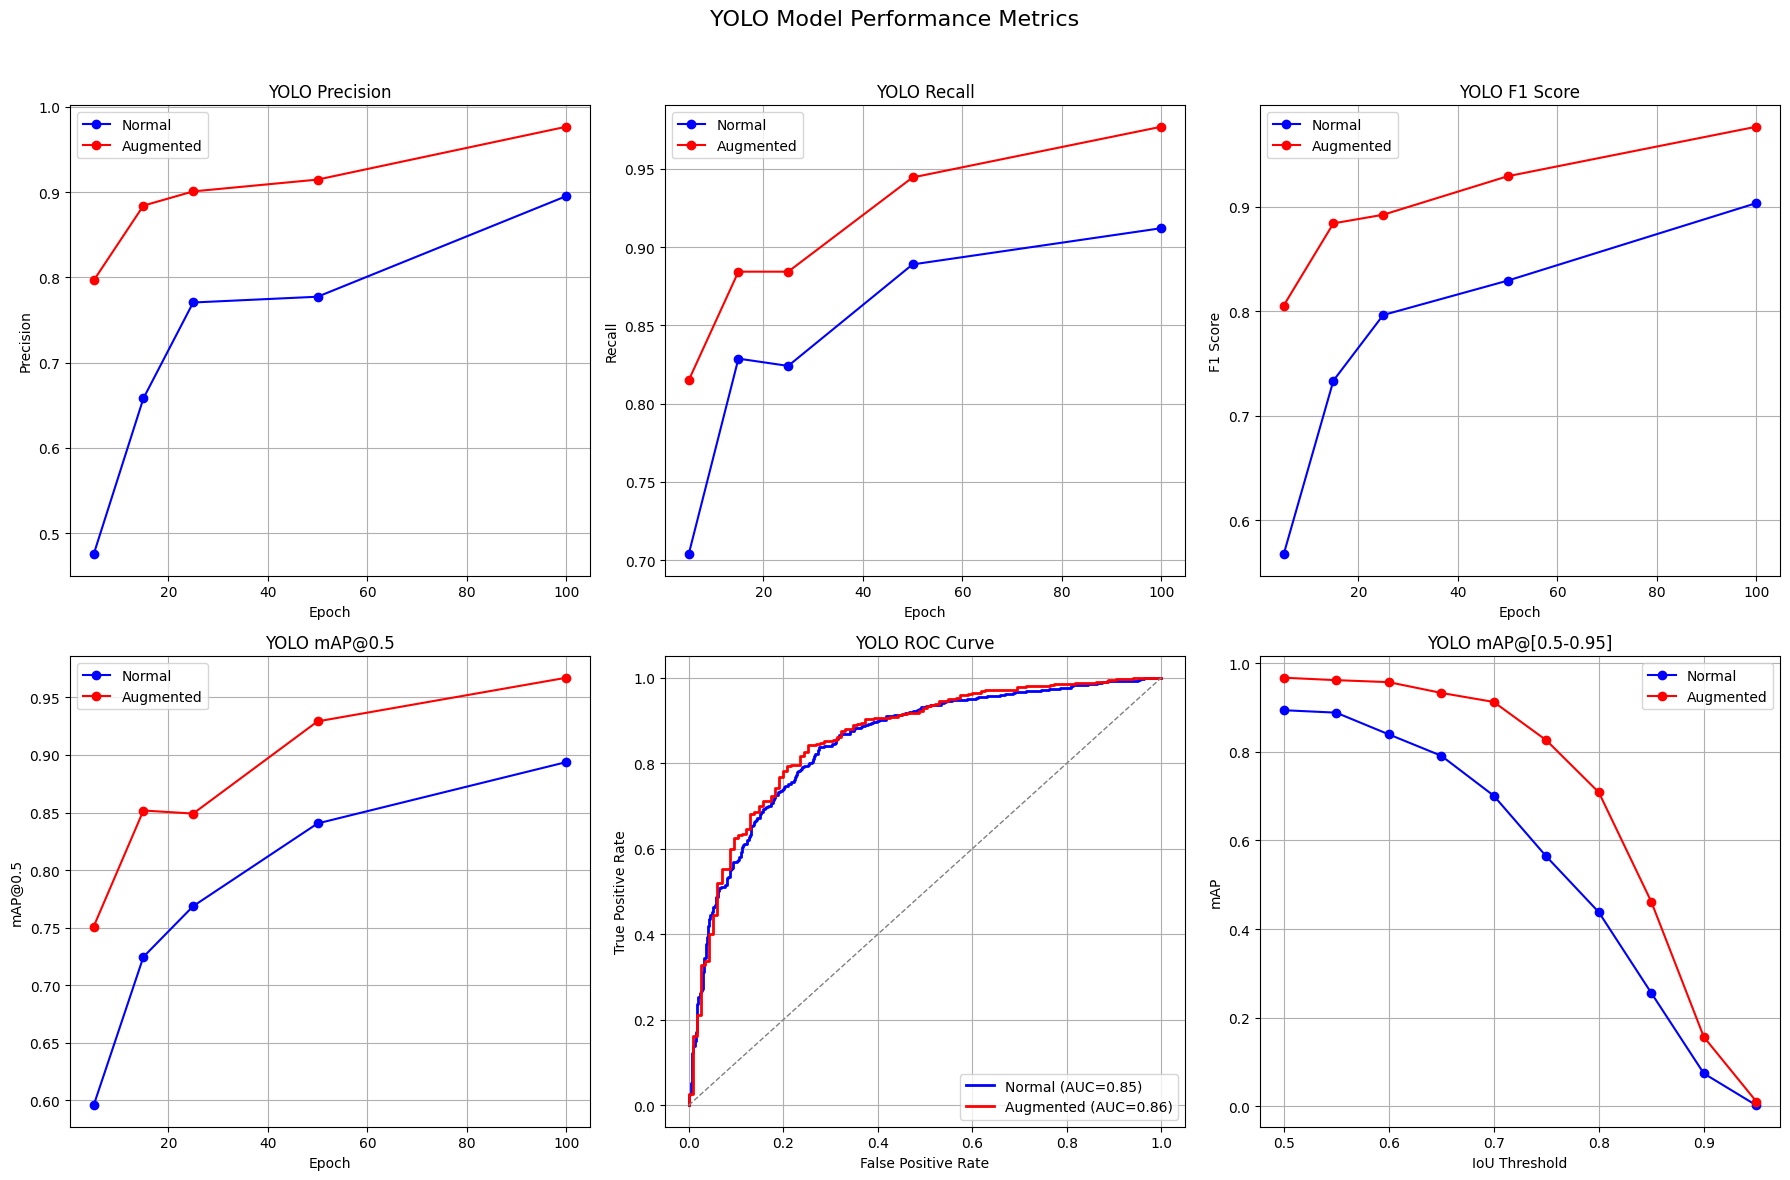

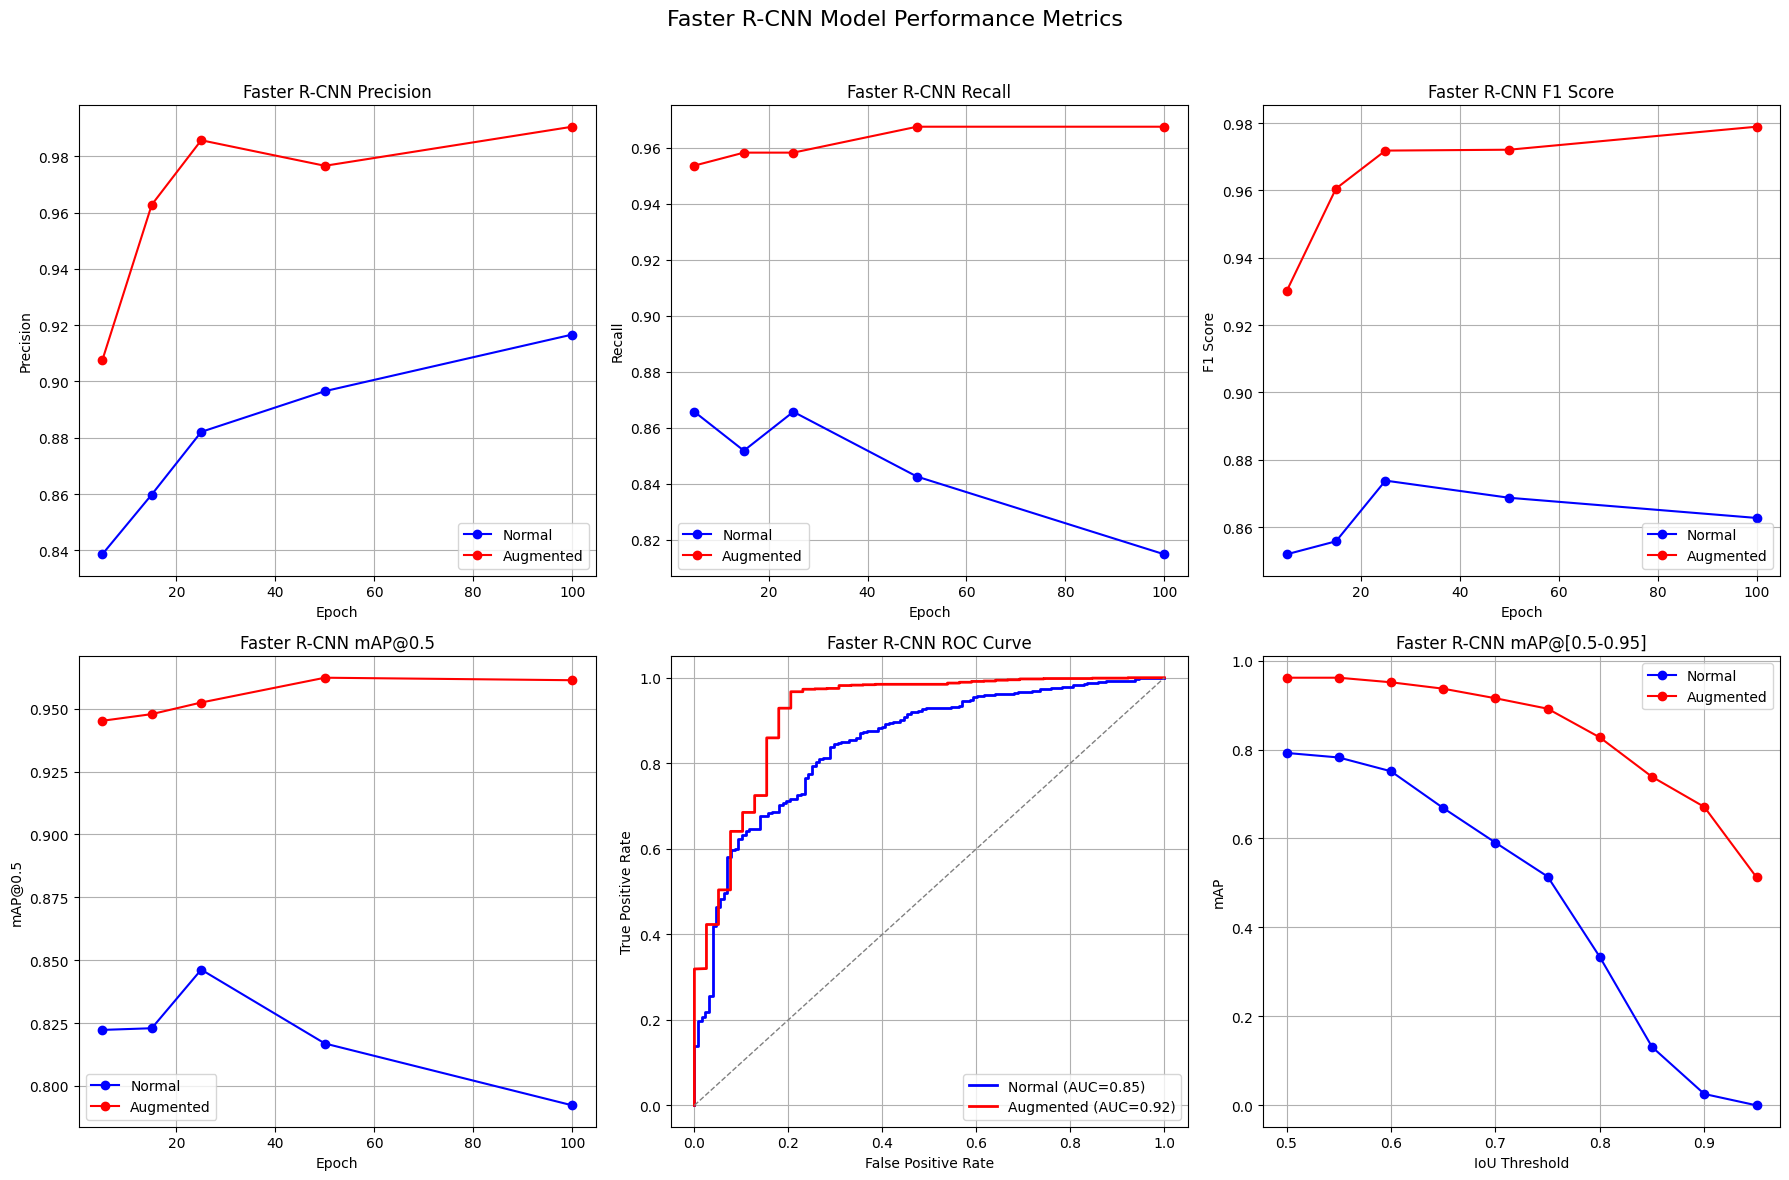

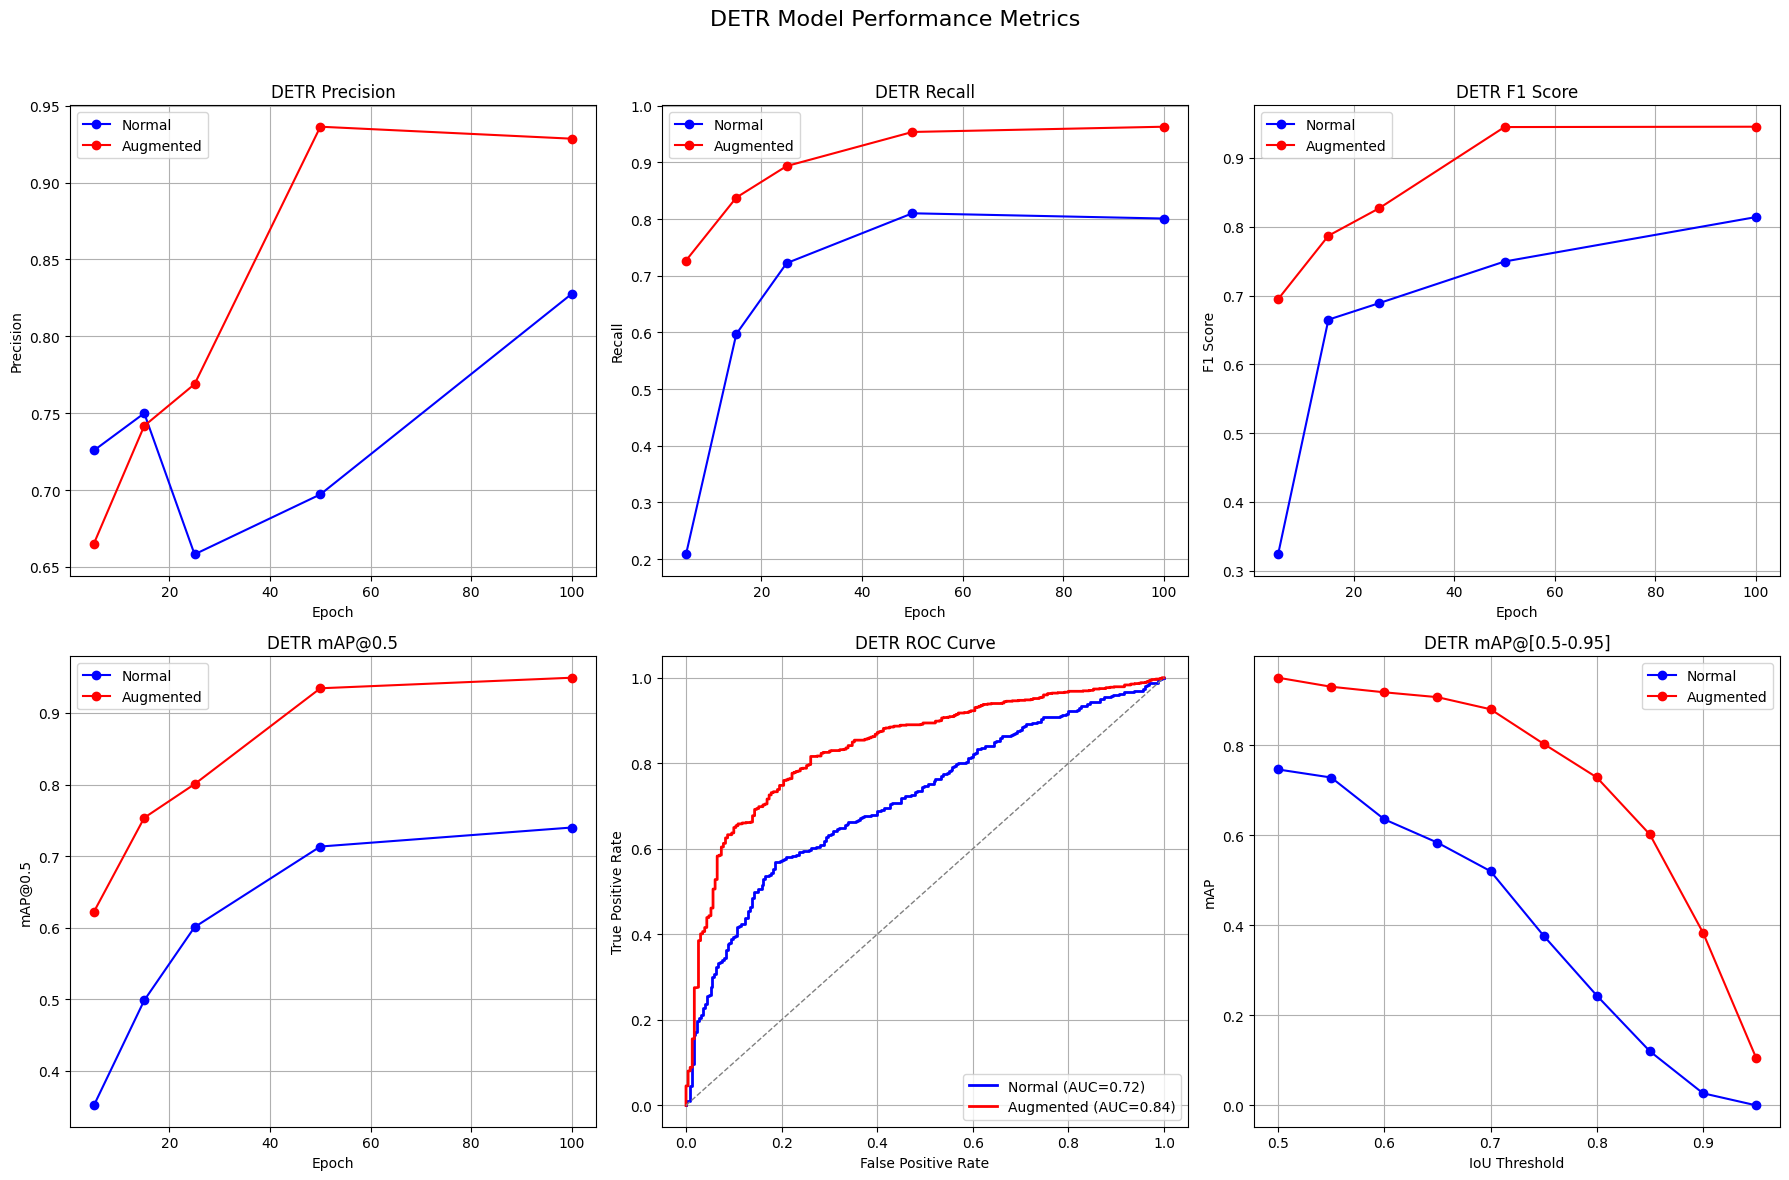


===== Best Model Comparison (Highest mAP) =====
Model           Epoch      Version       Prec     Recall        mAP
YOLO              100    augmented      0.977      0.977      0.967
FRCNN              50    augmented      0.977      0.968      0.962
DETR              100    augmented      0.929      0.963      0.949


In [13]:
from sklearn.metrics import roc_curve, auc

def sort_metrics(metrics_dict):
    """Sort metrics by epoch and separate normal and augmented results."""
    normal_epochs, normal_vals = [], {"precision": [], "recall": [], "f1": [], "mAP": [], "time": []}
    aug_epochs, aug_vals = [], {"precision": [], "recall": [], "f1": [], "mAP": [], "time": []}
    map_multi_normal = {}
    map_multi_aug = {}
    preds_normal = []
    preds_aug = []
    for (epoch, version), m in metrics_dict.items():
        # Skip the single entry with None (it is due to a now removed wrong file in DETR (it takes time to reevaluate everything))
        if epoch is None:
            continue
            
        if version == "normal":
            normal_epochs.append(epoch)
            normal_vals["precision"].append(m["precision"])
            normal_vals["recall"].append(m["recall"])
            normal_vals["f1"].append(m["f1"])
            normal_vals["mAP"].append(m["mAP"])
            normal_vals["time"].append(m["avg_inference_time"])
            map_multi_normal[epoch] = m["mAPs"]
            preds_normal.extend(m["all_preds"])
        else:
            aug_epochs.append(epoch)
            aug_vals["precision"].append(m["precision"])
            aug_vals["recall"].append(m["recall"])
            aug_vals["f1"].append(m["f1"])
            aug_vals["mAP"].append(m["mAP"])
            aug_vals["time"].append(m["avg_inference_time"])
            map_multi_aug[epoch] = m["mAPs"]
            preds_aug.extend(m["all_preds"])

    if normal_epochs:
        normal_epochs, [normal_vals["precision"], normal_vals["recall"], normal_vals["f1"], normal_vals["mAP"], normal_vals["time"]] = sort_by_epoch(normal_epochs, normal_vals["precision"], normal_vals["recall"], normal_vals["f1"], normal_vals["mAP"], normal_vals["time"])
    if aug_epochs:
        aug_epochs, [aug_vals["precision"], aug_vals["recall"], aug_vals["f1"], aug_vals["mAP"], aug_vals["time"]] = sort_by_epoch(aug_epochs, aug_vals["precision"], aug_vals["recall"], aug_vals["f1"], aug_vals["mAP"], aug_vals["time"])

    return normal_epochs, normal_vals, aug_epochs, aug_vals, map_multi_normal, map_multi_aug, preds_normal, preds_aug

yolo_metrics = ALL_METRICS["YOLO"]
frcnn_metrics = ALL_METRICS["FRCNN"]
detr_metrics = ALL_METRICS["DETR"]

# Process metrics for all model types
(yolo_norm_epochs, yolo_norm_vals, yolo_aug_epochs, yolo_aug_vals,
 yolo_map_multi_norm, yolo_map_multi_aug, yolo_preds_norm, yolo_preds_aug) = sort_metrics(yolo_metrics)

(frcnn_norm_epochs, frcnn_norm_vals, frcnn_aug_epochs, frcnn_aug_vals,
 frcnn_map_multi_norm, frcnn_map_multi_aug, frcnn_preds_norm, frcnn_preds_aug) = sort_metrics(frcnn_metrics)

(detr_norm_epochs, detr_norm_vals, detr_aug_epochs, detr_aug_vals,
 detr_map_multi_norm, detr_map_multi_aug, detr_preds_norm, detr_preds_aug) = sort_metrics(detr_metrics)

# Create ensemble plots with multiple subplots for each model type
def create_model_ensemble_plot(norm_epochs, norm_vals, aug_epochs, aug_vals, 
                              map_multi_norm, map_multi_aug, 
                              preds_norm, preds_aug,
                              model_name):
    """
    Create a figure with 6 subplots showing all metrics for a specific model type.
    
    Subplots include:
    1. Precision
    2. Recall
    3. F1 Score
    4. mAP@0.5
    5. mAP@0.5-0.95
    6. ROC Curve
    """
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f"{model_name} Model Performance Metrics", fontsize=16)

    axs = axs.flatten()
    
    # Plot 1: Precision
    axs[0].plot(norm_epochs, norm_vals["precision"], marker="o", color="blue", label="Normal")
    axs[0].plot(aug_epochs, aug_vals["precision"], marker="o", color="red", label="Augmented")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"{model_name} Precision")
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot 2: Recall
    axs[1].plot(norm_epochs, norm_vals["recall"], marker="o", color="blue", label="Normal")
    axs[1].plot(aug_epochs, aug_vals["recall"], marker="o", color="red", label="Augmented")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Recall")
    axs[1].set_title(f"{model_name} Recall")
    axs[1].legend()
    axs[1].grid(True)
    
    # Plot 3: F1 Score
    axs[2].plot(norm_epochs, norm_vals["f1"], marker="o", color="blue", label="Normal")
    axs[2].plot(aug_epochs, aug_vals["f1"], marker="o", color="red", label="Augmented")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("F1 Score")
    axs[2].set_title(f"{model_name} F1 Score")
    axs[2].legend()
    axs[2].grid(True)
    
    # Plot 4: mAP@0.5
    axs[3].plot(norm_epochs, norm_vals["mAP"], marker="o", color="blue", label="Normal")
    axs[3].plot(aug_epochs, aug_vals["mAP"], marker="o", color="red", label="Augmented")
    axs[3].set_xlabel("Epoch")
    axs[3].set_ylabel("mAP@0.5")
    axs[3].set_title(f"{model_name} mAP@0.5")
    axs[3].legend()
    axs[3].grid(True)
    
    # Plot 5: ROC Curve
    if preds_norm and preds_aug:
        scores_normal, labels_normal = zip(*preds_norm)
        scores_aug, labels_aug = zip(*preds_aug)
        
        fpr_norm, tpr_norm, _ = roc_curve(labels_normal, scores_normal)
        roc_auc_norm = auc(fpr_norm, tpr_norm)
        fpr_aug, tpr_aug, _ = roc_curve(labels_aug, scores_aug)
        roc_auc_aug = auc(fpr_aug, tpr_aug)
        
        axs[4].plot(fpr_norm, tpr_norm, color="blue", lw=2, label=f"Normal (AUC={roc_auc_norm:.2f})")
        axs[4].plot(fpr_aug, tpr_aug, color="red", lw=2, label=f"Augmented (AUC={roc_auc_aug:.2f})")
        axs[4].plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
        axs[4].set_xlabel("False Positive Rate")
        axs[4].set_ylabel("True Positive Rate")
        axs[4].set_title(f"{model_name} ROC Curve")
        axs[4].legend(loc="lower right")
        axs[4].grid(True)
    
    # Plot 6: mAP@[0.5-0.95]
    if map_multi_norm and map_multi_aug:
        best_norm_epoch = max(map_multi_norm.keys())
        best_aug_epoch = max(map_multi_aug.keys())
        normal_map_multi = map_multi_norm[best_norm_epoch]
        aug_map_multi = map_multi_aug[best_aug_epoch]
        iou_list = sorted(normal_map_multi.keys())
        
        axs[5].plot(iou_list, [normal_map_multi[i] for i in iou_list], marker="o", color="blue", label="Normal")
        axs[5].plot(iou_list, [aug_map_multi[i] for i in iou_list], marker="o", color="red", label="Augmented")
        axs[5].set_xlabel("IoU Threshold")
        axs[5].set_ylabel("mAP")
        axs[5].set_title(f"{model_name} mAP@[0.5-0.95]")
        axs[5].legend()
        axs[5].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Generate ensemble plots for each model type
# YOLO Ensemble Plot
if yolo_norm_epochs and yolo_aug_epochs:
    create_model_ensemble_plot(
        yolo_norm_epochs, yolo_norm_vals, 
        yolo_aug_epochs, yolo_aug_vals,
        yolo_map_multi_norm, yolo_map_multi_aug,
        yolo_preds_norm, yolo_preds_aug,
        "YOLO"
    )

# FRCNN Ensemble Plot
if frcnn_norm_epochs and frcnn_aug_epochs:
    create_model_ensemble_plot(
        frcnn_norm_epochs, frcnn_norm_vals, 
        frcnn_aug_epochs, frcnn_aug_vals,
        frcnn_map_multi_norm, frcnn_map_multi_aug,
        frcnn_preds_norm, frcnn_preds_aug,
        "Faster R-CNN"
    )

# DETR Ensemble Plot
if detr_norm_epochs and detr_aug_epochs:
    create_model_ensemble_plot(
        detr_norm_epochs, detr_norm_vals, 
        detr_aug_epochs, detr_aug_vals,
        detr_map_multi_norm, detr_map_multi_aug,
        detr_preds_norm, detr_preds_aug,
        "DETR"
    )

def pick_best_model(metrics_dict):
    """
    Given a dictionary of {(epoch, version) -> metrics}, find the key with the highest 'mAP'
    and return (best_key, best_metrics).
    """
    best_key = None
    best_map = -1
    best_metrics = None
    for k, v in metrics_dict.items():
        if v["mAP"] > best_map:
            best_map = v["mAP"]
            best_key = k
            best_metrics = v
    return best_key, best_metrics

best_yolo_key, best_yolo_metrics = pick_best_model(yolo_metrics) if yolo_metrics else ((None, None), {})
best_frcnn_key, best_frcnn_metrics = pick_best_model(frcnn_metrics) if frcnn_metrics else ((None, None), {})
best_detr_key, best_detr_metrics = pick_best_model(detr_metrics) if detr_metrics else ((None, None), {})

print("\n===== Best Model Comparison (Highest mAP) =====")
print("{:<10} {:>10} {:>12} {:>10} {:>10} {:>10}".format(
    "Model", "Epoch", "Version", "Prec", "Recall", "mAP"
))
if best_yolo_key and best_yolo_key[0] is not None:
    epoch, version = best_yolo_key
    print("{:<10} {:>10} {:>12} {:>10.3f} {:>10.3f} {:>10.3f}".format(
        "YOLO", epoch, version, best_yolo_metrics["precision"], best_yolo_metrics["recall"], best_yolo_metrics["mAP"]
    ))
else:
    print("YOLO (No data)")
if best_frcnn_key and best_frcnn_key[0] is not None:
    epoch, version = best_frcnn_key
    print("{:<10} {:>10} {:>12} {:>10.3f} {:>10.3f} {:>10.3f}".format(
        "FRCNN", epoch, version, best_frcnn_metrics["precision"], best_frcnn_metrics["recall"], best_frcnn_metrics["mAP"]
    ))
else:
    print("FRCNN (No data)")
if best_detr_key and best_detr_key[0] is not None:
    epoch, version = best_detr_key
    print("{:<10} {:>10} {:>12} {:>10.3f} {:>10.3f} {:>10.3f}".format(
        "DETR", epoch, version, best_detr_metrics["precision"], best_detr_metrics["recall"], best_detr_metrics["mAP"]
    ))
else:
    print("DETR (No data)")

## Visualise Predictions

Pick a random sample of images, and using the proven best model for each type, visualise some predictions.
This is to get a sense of how well the models are performing outside of pure metrics.

Visualizing sample predictions for best '100-augmented' models...


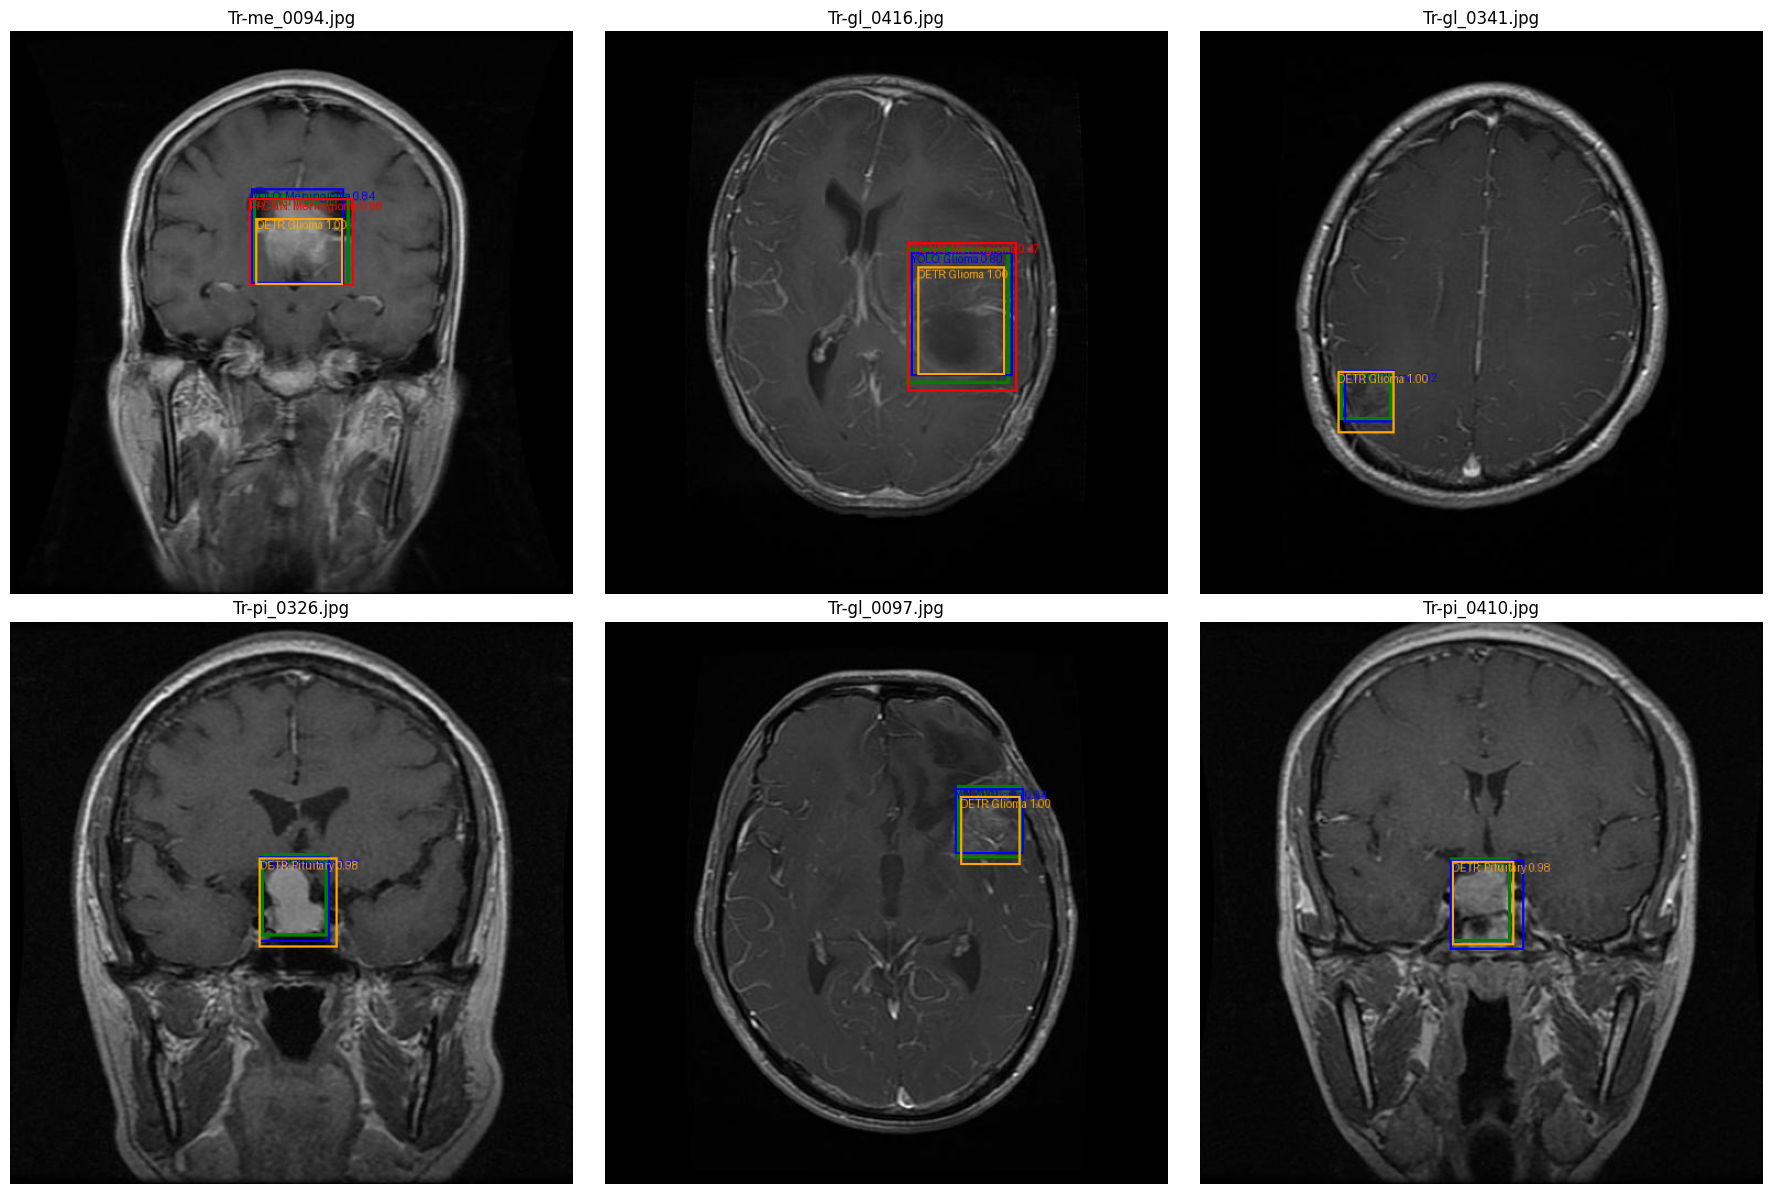

In [ ]:
print("Visualizing sample predictions for best '100-augmented' models...")

# Load best "100-augmented" YOLO model
from ultralytics import YOLO
yolo_model_best = YOLO("./models/YOLOv11/augmented-100.pt", verbose=False)

# Load best "100-augmented" FRCNN model
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Can't use 'mps' device for Faster R-CNN as it isn't yet supported.
frcnn_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

frcnn_model_best = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone="DEFAULT")
in_features = frcnn_model_best.roi_heads.box_predictor.cls_score.in_features
num_classes = 5  # background + 4 tumor classes
frcnn_model_best.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
frcnn_state = torch.load("./models/FRCNN/frcnn_100-augmented.pth", map_location=frcnn_device)
frcnn_model_best.load_state_dict(frcnn_state)
frcnn_model_best.to(frcnn_device)


if torch.cuda.is_available():
    detr_device = torch.device("cuda")
elif torch.mps.is_available():
    detr_device = torch.device("mps")
else:
    detr_device = torch.device("cpu")
# Load best "100-augmented" DETR model and its processor
from transformers import DetrForObjectDetection, AutoImageProcessor
detr_model_best = DetrForObjectDetection.from_pretrained("./models/DETR/detr-augmented-100")
detr_processor_best = AutoImageProcessor.from_pretrained("./models/DETR/detr-augmented-100")
detr_model_best.to(detr_device)

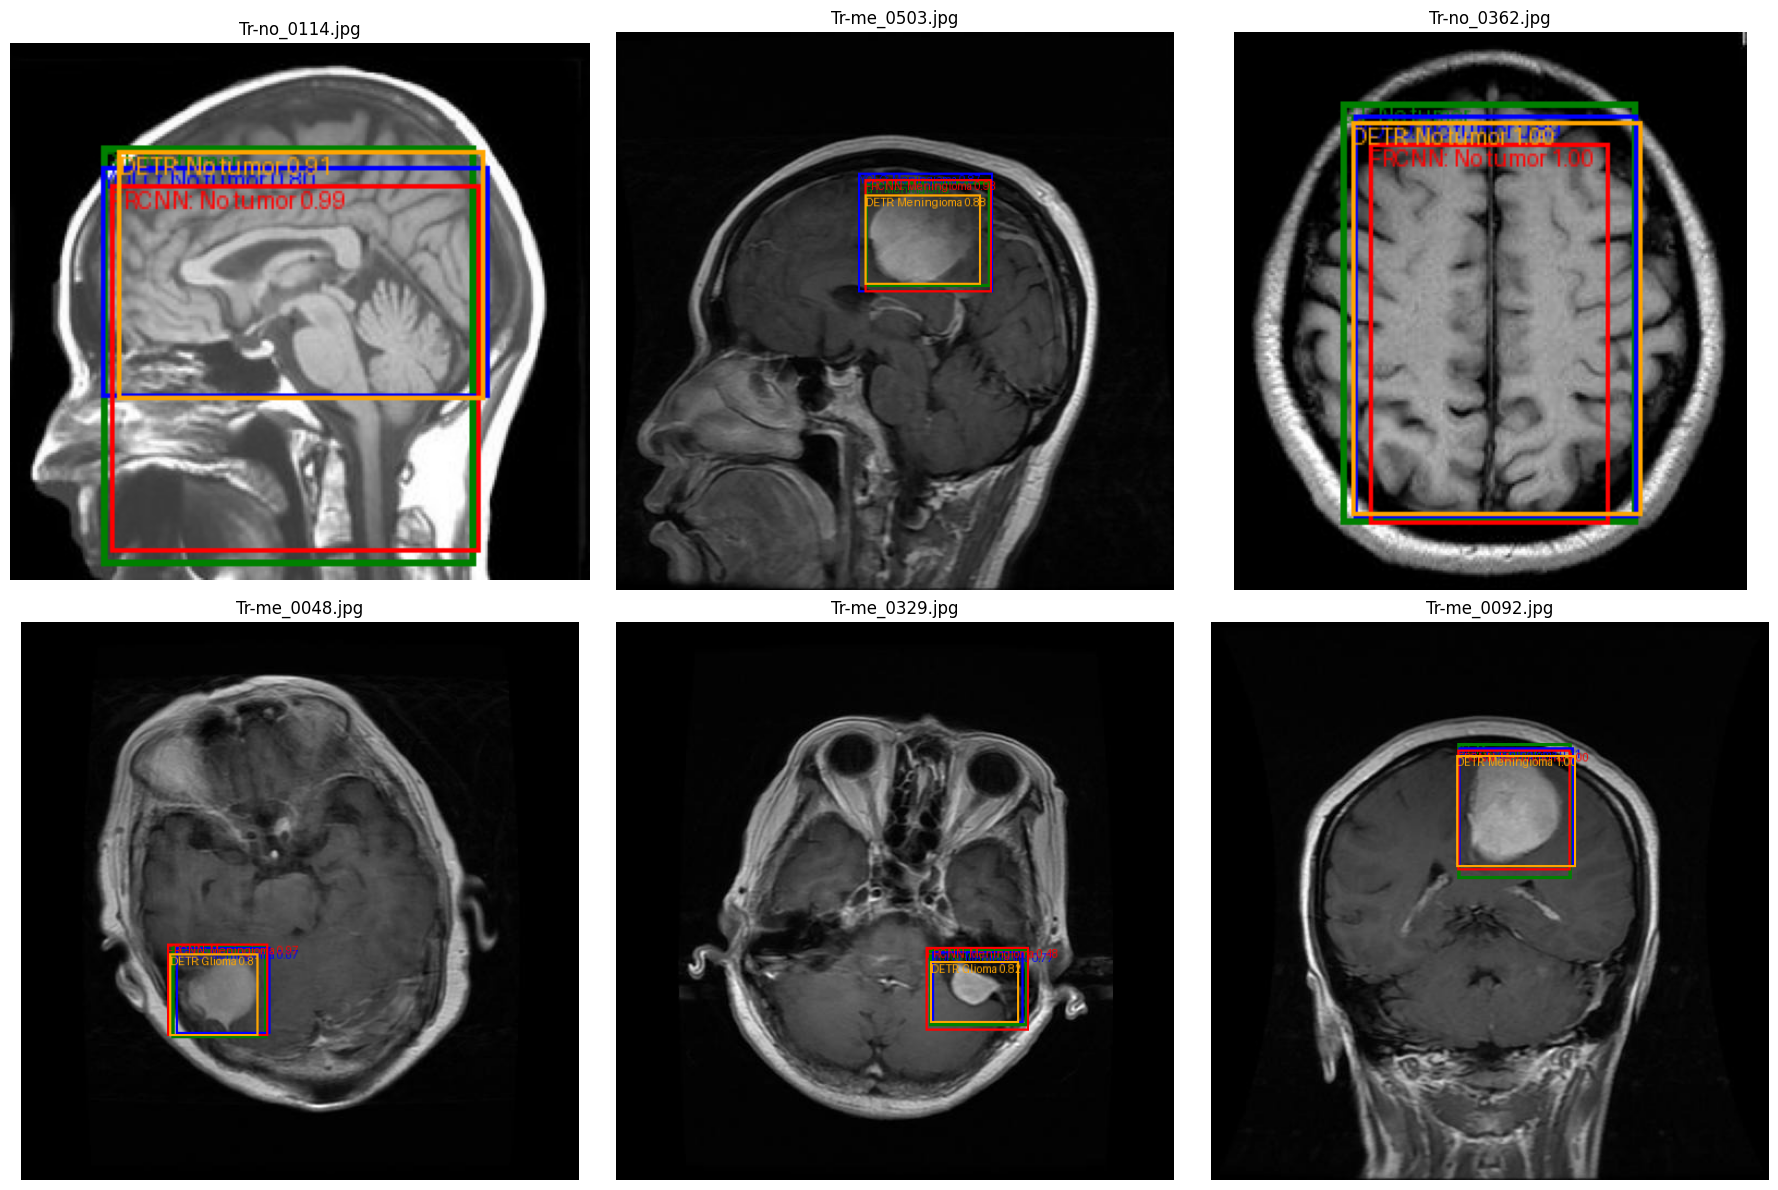

In [29]:
visualizer = MultiModelVisualizer(
    yolo_model=yolo_model_best,
    frcnn_model=frcnn_model_best,
    detr_model=detr_model_best,
    detr_processor=detr_processor_best,
    frcnn_transform=T.Compose([T.ToTensor()]),
    yolo_conf=0.0,
    frcnn_conf=0.0,
    detr_conf=0.0
)

# Pick a sample batch of images from the validation set
from pathlib import Path
import random
image_dir = Path(test_dataset_dir) / "validation" / "images"
image_paths = [str(f) for f in random.sample(list(image_dir.glob("*.jpg")), min(6, len(list(image_dir.glob("*.jpg")))))]
visualizer.visualize_batch(image_paths, class_names={0:"Pituitary", 1:"Meningioma", 2:"Glioma", 3:"No tumor"})